# Running the RONIN RESNET to evaluate performance

In [1]:
import os
from os import path as osp
import torch
from torch.utils.data import DataLoader
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d

import ronin
from ronin.transformations import RandomHoriRotate
from ronin.data_glob_speed import GlobSpeedSequence,StridedSequenceDataset
from ronin.data_ridi import RIDIGlobSpeedSequence
from ronin.model_resnet1d import ResNet1D,BasicBlock1D,FCOutputModule
from ronin.metric import compute_ate_rte

In [2]:
#original command:
# python ./ronin/ronin/ronin_resnet.py 
# --mode test 
# --test_list ./ronin/lists/SHORT_list_test_unseen.txt 
# --root_dir ./ronin_dataset/unseen_subjects_test_set 
# --out_dir ./ronin/output/resnet_out \
# --model_path ./ronin/ronin/models/ronin_resnet/checkpoint_gsn_latest.pt

## Setting main variables used by the notebook

In [3]:
#define key variables
root_dir = "/data/imu-ml-security-project/Data"
test_list = "../lists/SHORT_list_test_unseen.txt"
out_dir = "../output/resnet_out"
model_path = "/data/imu-ml-security-project/Pretrained_Models/ronin_resnet/checkpoint_gsn_latest.pt"
cache_path = None
step_size = 10
window_size = 200
max_ori_error = 20.0
cpu = True

#initialize the global variables
_input_channel, _output_channel = 6, 2
_fc_config = {'fc_dim': 512, 'in_dim': 7, 'dropout': 0.5, 'trans_planes': 128}

## Defining Functions used by the notebook

In [4]:
#use the get dataset function
def get_dataset(
        root_dir,
        data_list,
        mode="test",
        step_size=10,
        window_size=200,
        max_ori_error=20,
        dataset="ronin",
        cache_path=None):

    random_shift, shuffle, transforms, grv_only = 0, False, None, False
    if mode == 'train':
        random_shift = step_size // 2
        shuffle = True
        transforms = RandomHoriRotate(math.pi * 2)
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True

    if dataset == 'ronin':
        seq_type = GlobSpeedSequence
    elif dataset == 'ridi':
        seq_type = RIDIGlobSpeedSequence
    
    dataset = StridedSequenceDataset(
        seq_type=seq_type,
        root_dir=root_dir,
        data_list=data_list,
        cache_path=cache_path,
        step_size=step_size,
        window_size=window_size,
        random_shift=random_shift,
        transform=transforms,
        shuffle=shuffle,
        grv_only=grv_only,
        max_ori_error=max_ori_error
    )

    global _input_channel,_output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset

def get_model(arch="resnet18"):

    #state that using the global _fc_config variable
    global _fc_config

    if arch == 'resnet18':
        network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)
    elif arch == 'resnet50':
        # For 1D network, the Bottleneck structure results in 2x more parameters, therefore we stick to BasicBlock.
        _fc_config['fc_dim'] = 1024
        network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [3, 4, 6, 3],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)
    elif arch == 'resnet101':
        _fc_config['fc_dim'] = 1024
        network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [3, 4, 23, 3],
                           base_plane=64, output_block=FCOutputModule, **_fc_config)
    else:
        raise ValueError('Invalid architecture: ', arch)
    return network

def run_test(network,data_loader,device,eval_mode=True):
    targets_all = []
    preds_all = []
    if eval_mode:
        network.eval()
    for bid, (feat, targ, _, _) in enumerate(data_loader):
        pred = network(feat.to(device)).cpu().detach().numpy()
        targets_all.append(targ.detach().numpy())
        preds_all.append(pred)
    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    return targets_all, preds_all

def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int32)
    dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])
    pos = np.zeros([preds.shape[0] + 2, 2])
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    pos = interp1d(ts_ext, pos, axis=0)(ts)
    return pos

## Preparing to run the code

In [5]:
#setup the list of test datasets
with open(test_list) as f:
    test_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
print(test_data_list)

#setup the out directory
if not osp.isdir(out_dir):
    os.makedirs(out_dir)


['a006_2', 'a019_3', 'a024_1', 'a024_3', 'a029_1', 'a029_2', 'a032_1', 'a032_3']


In [6]:
print(out_dir)

../output/resnet_out


In [7]:
#setup cuda
if not torch.cuda.is_available() or cpu:
    device = torch.device('cpu')
    checkpoint = torch.load(model_path, map_location=lambda storage, location: storage)
    print("loaded model to CPU")
else:
    device = torch.device('cuda:0')
    checkpoint = torch.load(model_path)
    print("loaded model to {}".format(device))

loaded model to CPU


/tmp/ipykernel_1813188/1738976256.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=lambda storage, location: storage)


In [8]:
#initializing the dataset
_=get_dataset(
    root_dir=root_dir,
    data_list=[test_data_list[0]],
    mode="test",
    step_size=step_size,
    window_size=window_size,
    max_ori_error=max_ori_error,
    dataset="ronin",
    cache_path=cache_path
)

print("dataset loaded with input channels: {}, output channels: {}".format(
    _input_channel,_output_channel
))

a006_2: device: samsung1, ori_error (game_rv): 3.978
dataset loaded with input channels: 6, output channels: 2


In [9]:
#setup the model
_fc_config['in_dim'] = window_size // 32 + 1

network = get_model(arch="resnet18")
print(_fc_config)

#load the pre-trained weights
network.load_state_dict(checkpoint["model_state_dict"])

#put the model in eval mode
network.eval().to(device)

print('Model {} loaded to device {}.'.format(model_path, device))

#setup the various metrics to be stored
preds_seq, targets_seq, losses_seq, ate_all, rte_all = [], [], [], [], []
traj_lens = []
pred_per_min = 200 * 60

{'fc_dim': 512, 'in_dim': 7, 'dropout': 0.5, 'trans_planes': 128}
Model /data/imu-ml-security-project/Pretrained_Models/ronin_resnet/checkpoint_gsn_latest.pt loaded to device cpu.


## Testing on a particular sample of the dataset

In [10]:
#load the dataset
dataset_idx = 0
sample_idx = 200
print("evaluating on dataset: {}".format(test_data_list[dataset_idx]))
seq_dataset = get_dataset(
    root_dir=root_dir,
    data_list=[test_data_list[dataset_idx]],
    mode="test",
    step_size=step_size,
    window_size=window_size,
    max_ori_error=max_ori_error,
    dataset="ronin",
    cache_path=cache_path
)

evaluating on dataset: a006_2
a006_2: device: samsung1, ori_error (game_rv): 3.978


input dimmensions: (6, 200)
output: [-0.03652771  0.06860664] m/s
Model output: [-0.00466157  0.01411259]m/s


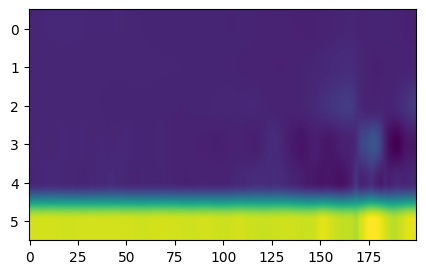

In [11]:
#plot the input and print the output
feat, targ, seq_id, frame_id = seq_dataset.__getitem__(item=sample_idx)
plt.figure(figsize=(5,3))
plt.imshow(feat,aspect="auto")
print("input dimmensions: {}\noutput: {} m/s".format(feat.shape,targ))

#make the prediction
feat = torch.Tensor(feat).unsqueeze(0)
pred = network(feat.to(device)).cpu().detach().numpy()
print("Model output: {}m/s".format(pred[0]))

## Testing over an entire dataset (by iterating)

In [12]:
#initialize the dataset
dataset_idx = 0
print("evaluating on dataset: {}".format(test_data_list[dataset_idx]))
seq_dataset = get_dataset(
    root_dir=root_dir,
    data_list=[test_data_list[dataset_idx]],
    mode="test",
    step_size=step_size,
    window_size=window_size,
    max_ori_error=max_ori_error,
    dataset="ronin",
    cache_path=cache_path
)
ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=np.int32)

evaluating on dataset: a006_2
a006_2: device: samsung1, ori_error (game_rv): 3.978


In [13]:
targets_all = []
preds_all = []

#put the network in eval mode:
network.eval()

feat_ex = None

for i in tqdm(range(seq_dataset.__len__())):
    feat, targ, seq_id, frame_id = seq_dataset.__getitem__(item=i)
    if i ==0:
        feat_ex = feat

    if i == 0:
        print("First: ", feat.shape)
    #convert feature and target to tensor
    feat = torch.Tensor(feat).unsqueeze(0)
    if i == 0:
        print(feat.shape)

    #make the prediction
    pred = network(feat.to(device)).cpu().detach().numpy()

    #save the results
    targets_all.append(np.array([targ]))
    preds_all.append(pred)

targets_all = np.concatenate(targets_all, axis=0)
preds_all = np.concatenate(preds_all, axis=0)
print(targets_all.shape)
print(preds_all.shape)

  0%|          | 38/16737 [00:00<00:44, 375.86it/s]

First:  (6, 200)
torch.Size([1, 6, 200])


100%|██████████| 16737/16737 [00:37<00:00, 445.82it/s]

(16737, 2)
(16737, 2)


In [15]:
feat_ex.shape

(6, 200)

In [16]:
feat_ex[0].shape

(200,)

In [17]:
type(preds_all)

numpy.ndarray

In [18]:
targets_all[0]

array([-8.1140388e-05,  4.7965604e-03], dtype=float32)

In [19]:
preds_all[0]

array([-2.8271688e-05, -3.1123578e-05], dtype=float32)

In [20]:
mean_axis0 = np.mean(feat_ex, axis=1)
median_axis0 = np.median(feat_ex, axis=1)
std_dev_axis0 = np.std(feat_ex, axis=1)
variance_axis0 = np.var(feat_ex, axis=1)
minimum_axis0 = np.min(feat_ex, axis=1)
maximum_axis0 = np.max(feat_ex, axis=1)

# Display the results
print("Summary Statistics (Column-Wise - axis=0):")
print(f"Mean (axis=0): {mean_axis0}")
print(f"Median (axis=0): {median_axis0}")
print(f"Standard Deviation (axis=0): {std_dev_axis0}")
print(f"Variance (axis=0): {variance_axis0}")
print(f"Minimum (axis=0): {minimum_axis0}")
print(f"Maximum (axis=0): {maximum_axis0}")

Summary Statistics (Column-Wise - axis=0):
Mean (axis=0): [-1.0769309e-03  6.4403645e-04 -2.3779022e-03 -1.2579176e-01
 -2.1928472e-02  9.8276596e+00]
Median (axis=0): [-1.0193968e-03  4.2592693e-04 -1.5204097e-03 -1.3665710e-01
 -1.7197853e-02  9.8256845e+00]
Standard Deviation (axis=0): [0.00259651 0.00392457 0.0094053  0.04636588 0.02166757 0.03224735]
Variance (axis=0): [6.7418878e-06 1.5402255e-05 8.8459681e-05 2.1497945e-03 4.6948358e-04
 1.0398916e-03]
Minimum (axis=0): [-6.2171197e-03 -6.2613343e-03 -2.7250759e-02 -2.0843188e-01
 -8.1613056e-02  9.7596197e+00]
Maximum (axis=0): [ 5.46386326e-03  1.09270448e-02  1.53067475e-02 -2.30884831e-02
  2.07722690e-02  9.90734386e+00]


### HSJA

In [21]:
def predict_wrapper(model, input_data):
    #import tensorflow as tf
    import torch
    from sklearn.base import BaseEstimator

    if isinstance(model, torch.nn.Module):  # PyTorch model
        with torch.no_grad():
            # Convert input data to PyTorch tensor
            sample_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

            # Handle input dimensions
            if len(sample_tensor.shape) == 3:  # Already batched (N, C, L)
                #print("Input already batched:", sample_tensor.shape)
                pass
            elif len(sample_tensor.shape) == 2:  # Single image (C, L)
                sample_tensor = sample_tensor.unsqueeze(0)  # Add batch dimension
                #print("Batch dimension added:", sample_tensor.shape)
            else:
                raise ValueError(f"Unexpected input shape: {sample_tensor.shape}")

            # Pass the tensor through the model
            return model(sample_tensor).cpu().numpy()

    elif isinstance(model, BaseEstimator):  # Scikit-learn model
        return model.predict_proba(input_data)

    else:
        raise ValueError("Unsupported model type")


In [90]:
import numpy as np

def hsja(model,
	sample,
	clip_max = 1,
	clip_min = 0,
	constraint = 'l2',
	num_iterations = 40,
	gamma = 1.0,
	target_label = None,
	target_image = None,
	stepsize_search = 'geometric_progression',
	max_num_evals = 1e4,
	init_num_evals = 100,
	verbose = True,
	alpha = 1,
	beta = 0.05,
	clip_min_gyro = -10.97,
	clip_max_gyro = 7.44,
	clip_min_acc = -38.82,
	clip_max_acc = 34.20):
	"""
	Main algorithm for HopSkipJumpAttack.

	Inputs:
	model: the object that has predict method.

	predict outputs probability scores.

	clip_max: upper bound of the image.

	clip_min: lower bound of the image.

	constraint: choose between [l2, linf].

	num_iterations: number of iterations.

	gamma: used to set binary search threshold theta. The binary search
	threshold theta is gamma / d^{3/2} for l2 attack and gamma / d^2 for
	linf attack.

	target_label: integer or None for nontargeted attack.

	target_image: an array with the same size as sample, or None.

	stepsize_search: choose between 'geometric_progression', 'grid_search'.

	max_num_evals: maximum number of evaluations for estimating gradient (for each iteration).
	This is not the total number of model evaluations for the entire algorithm, you need to
	set a counter of model evaluations by yourself to get that. To increase the total number
	of model evaluations, set a larger num_iterations.

	init_num_evals: initial number of evaluations for estimating gradient.

	alpha: weight on change in magnitude for ellipsoid artficial boundary 

	beta: weight on change in direction for ellipsoid artficial boundary 

	Output:
	perturbed image.

	"""
	# Set parameters
	original_label = predict_wrapper(model, sample).squeeze()
	#print(original_label.shape)

	x_velocity = original_label[0]
	y_velocity = original_label[1]

	#original_label = np.argmax(model.predict(sample))
	params = {'clip_max': clip_max, 'clip_min': clip_min,
				'shape': sample.shape,
				'original_label': original_label,
				'target_label': target_label,
				'target_image': target_image,
				'constraint': constraint,
				'num_iterations': num_iterations,
				'gamma': gamma,
				'd': int(np.prod(sample.shape)),
				'stepsize_search': stepsize_search,
				'max_num_evals': max_num_evals,
				'init_num_evals': init_num_evals,
				'verbose': verbose,
				'alpha' : alpha,
				'beta' : beta,
				'x_velocity' : x_velocity,
				'y_velocity' : y_velocity,
				"clip_min_gyro": clip_min_gyro,
				"clip_max_gyro": clip_max_gyro,
				"clip_min_acc": clip_min_acc,
				"clip_max_acc": clip_max_acc

				}

	# Set binary search threshold.
	if params['constraint'] == 'l2':
		params['theta'] = params['gamma'] / (np.sqrt(params['d']) * params['d'])
	else:
		params['theta'] = params['gamma'] / (params['d'] ** 2)

	# Initialize.
	perturbed = initialize(model, sample, params)


	# Project the initialization to the boundary.
	perturbed, dist_post_update = binary_search_batch(sample,
		np.expand_dims(perturbed, 0),
		model,
		params)
	dist = compute_distance(perturbed, sample, constraint)

	for j in np.arange(params['num_iterations']):
		params['cur_iter'] = j + 1

		# Choose delta.
		#delta = select_delta(params, dist_post_update)
		delta = 0.005 * (params['clip_max_gyro'] - params['clip_min_gyro'])

		# Choose number of evaluations.
		num_evals = int(params['init_num_evals'] * np.sqrt(j+1))
		num_evals = int(min([num_evals, params['max_num_evals']]))

		# approximate gradient.
		gradf = approximate_gradient(model, perturbed, num_evals,
			delta, params)
		if params['constraint'] == 'linf':
			update = np.sign(gradf)
		else:
			update = gradf

		# search step size.
		if params['stepsize_search'] == 'geometric_progression':
			# find step size.
			epsilon = geometric_progression_for_stepsize(perturbed,
				update, dist, model, params)
			
			epsilon = min(dist / np.sqrt(params['cur_iter']), epsilon * 0.9)
			epsilon = min(epsilon, 0.1 * np.linalg.norm(gradf))
			#print(f"Iteration {params['cur_iter']} - Epsilon: {epsilon}")

			# Update the sample.
			#perturbed = clip_image(perturbed + epsilon * update,
			#	clip_min, clip_max)
			
			perturbed = clip_gyro(perturbed + epsilon * update, params['clip_min_gyro'], params['clip_max_gyro'])
			perturbed = clip_acc(perturbed + epsilon * update, params['clip_min_acc'], params['clip_max_acc'])

			# Binary search to return to the boundary.
			perturbed, dist_post_update = binary_search_batch(sample,
				perturbed[None], model, params)

		elif params['stepsize_search'] == 'grid_search':
			# Grid search for stepsize.
			epsilons = np.logspace(-4, 0, num=20, endpoint = True) * dist
			epsilons_shape = [20] + len(params['shape']) * [1]
			perturbeds = perturbed + epsilons.reshape(epsilons_shape) * update
			#perturbeds = clip_image(perturbeds, params['clip_min'], params['clip_max'])
			perturbed = clip_gyro(perturbeds, params['clip_min_gyro'], params['clip_max_gyro'])
			perturbed = clip_acc(perturbeds, params['clip_min_acc'], params['clip_max_acc'])
			#idx_perturbed = decision_function(model, perturbeds, params)
			idx_perturbed = vector_decision_function(model, perturbeds, params)


			if np.sum(idx_perturbed) > 0:
				# Select the perturbation that yields the minimum distance # after binary search.
				perturbed, dist_post_update = binary_search_batch(sample,
					perturbeds[idx_perturbed], model, params)

		# compute new distance.
		dist = compute_distance(perturbed, sample, constraint)
		if verbose:
			print('iteration: {:d}, {:s} distance {:.4E}'.format(j+1, constraint, dist))

	return perturbed

def vector_decision_function(model, images, params):
	"""
	Decision function output for vectors 1 on the desired side of the artificial boundary,
	0 otherwise.
	"""

	#images = clip_image(images, params['clip_min'], params['clip_max'])

	images = clip_gyro(images, params['clip_min_gyro'], params['clip_max_gyro'])
	images = clip_acc(images, params['clip_min_acc'], params['clip_max_acc'])

	prob = predict_wrapper(model, images).squeeze()

	#predictions = np.argmax(prob, axis=1)
	#print(f"Predictions: {predictions}, Original Label: {params['original_label']}")

	v = np.array([params["x_velocity"], params["y_velocity"]])
	v_adv = prob

	#print("Vshape ", v.shape)
	#print("Vadvshape ", v_adv.shape)

	# Calculate dot product of v and v_adv
	dot_product = np.dot(v, v_adv)

	# Calculate magnitudes of v and v_adv
	magnitude_v = np.linalg.norm(v)
	magnitude_v_adv = np.linalg.norm(v_adv)

	# Calculate the expressions for change in magnitude and direction wrt original prediction
	epsilon = 1e-8
	chg_mag = np.abs(magnitude_v - magnitude_v_adv)
	chg_dir = dot_product / (magnitude_v * magnitude_v_adv + epsilon)

	alpha = params["alpha"]
	beta = params["beta"]

	dist_from_orig_pred = alpha * chg_mag - beta * chg_dir
	threshold = 0.01 * np.linalg.norm(params["original_label"])
	res = dist_from_orig_pred > threshold
	#print(res)
	
	return res


def decision_function(model, images, params):
	"""
	Decision function output 1 on the desired side of the boundary,
	0 otherwise.
	"""
	images = clip_image(images, params['clip_min'], params['clip_max'])
	prob = predict_wrapper(model, images)

	#predictions = np.argmax(prob, axis=1)
	#print(f"Predictions: {predictions}, Original Label: {params['original_label']}")

	#prob = model.predict(images)
	if params['target_label'] is None:
		#result = predictions != params['original_label']
		#print(f"Decision Result (Untargeted): {result}")
		return np.argmax(prob, axis = 1) != params['original_label']
	else:
		return np.argmax(prob, axis = 1) == params['target_label']

def clip_image(image, clip_min, clip_max):
	# Clip an image, or an image batch, with upper and lower threshold.
	return np.minimum(np.maximum(clip_min, image), clip_max)

def clip_gyro(image, gyro_clip_min, gyro_clip_max):
    # Clip the first three rows in-place
    image[:3] = clip_image(image[:3], gyro_clip_min, gyro_clip_max)
    return image

def clip_acc(image, acc_clip_min, acc_clip_max):
    # Clip the last three rows in-place
    image[3:] = clip_image(image[3:], acc_clip_min, acc_clip_max)
    return image

def compute_distance(x_ori, x_pert, constraint = 'l2'):
	# Compute the distance between two images.
	if constraint == 'l2':
		return np.linalg.norm(x_ori - x_pert)
	elif constraint == 'linf':
		return np.max(abs(x_ori - x_pert))


def approximate_gradient(model, sample, num_evals, delta, params):
	clip_max, clip_min = params['clip_max'], params['clip_min']

	# Generate random vectors.
	noise_shape = [num_evals] + list(params['shape'])
	#print(noise_shape)
	if params['constraint'] == 'l2':
		rv = np.random.randn(*noise_shape)
	elif params['constraint'] == 'linf':
		rv = np.random.uniform(low = -1, high = 1, size = noise_shape)

	#print(rv.shape)
	rv = rv / np.sqrt(np.sum(rv ** 2, axis = (1,2), keepdims = True))
	#print(rv.shape)
	perturbed = sample + delta * rv
	#perturbed = clip_image(perturbed, clip_min, clip_max)
	perturbed = clip_gyro(perturbed, params['clip_min_gyro'], params['clip_max_gyro'])
	perturbed = clip_acc(perturbed, params['clip_min_acc'], params['clip_max_acc'])
	rv = (perturbed - sample) / delta

	# query the model.
	#decisions = decision_function(model, perturbed, params)
	#print("Sample shape ", sample.shape)
	#print("2")

	results = []
	for vector in perturbed:
		results.append(vector_decision_function(model, vector, params))  # Call the function for each vector

	# Convert results to a numpy array for convenience
	results = np.array(results)

	#decisions = vector_decision_function(model, perturbed, params)
	decisions = results
	
	decision_shape = [len(decisions)] + [1] * len(params['shape'])
	fval = 2 * decisions.astype(float).reshape(decision_shape) - 1.0

	# Baseline subtraction (when fval differs)
	if np.mean(fval) == 1.0: # label changes.
		gradf = np.mean(rv, axis = 0)
	elif np.mean(fval) == -1.0: # label not change.
		gradf = - np.mean(rv, axis = 0)
	else:
		fval -= np.mean(fval)
		gradf = np.mean(fval * rv, axis = 0)

	# Get the gradient direction.
	#gradf = gradf / np.linalg.norm(gradf)

	grad_norm = np.linalg.norm(gradf)
	if grad_norm < 1e-8:  # Avoid division by zero or overly small gradients
		gradf = gradf * 0
	else:
		gradf /= grad_norm

	###print(f"Iteration {params['cur_iter']} - Gradient Norm: {grad_norm}")


	return gradf


def project(original_image, perturbed_images, alphas, params):
	alphas_shape = [len(alphas)] + [1] * len(params['shape'])
	alphas = alphas.reshape(alphas_shape)
	if params['constraint'] == 'l2':
		return (1-alphas) * original_image + alphas * perturbed_images
	elif params['constraint'] == 'linf':
		out_images = clip_image(
			perturbed_images,
			original_image - alphas,
			original_image + alphas
			)
		return out_images


def binary_search_batch(original_image, perturbed_images, model, params):
	""" Binary search to approach the boundar. """

	# Compute distance between each of perturbed image and original image.
	dists_post_update = np.array([
			compute_distance(
				original_image,
				perturbed_image,
				params['constraint']
			)
			for perturbed_image in perturbed_images])

	# Choose upper thresholds in binary searchs based on constraint.
	if params['constraint'] == 'linf':
		highs = dists_post_update
		# Stopping criteria.
		thresholds = np.minimum(dists_post_update * params['theta'], params['theta'])
	else:
		highs = np.ones(len(perturbed_images))
		thresholds = params['theta']

	lows = np.zeros(len(perturbed_images))



	# Call recursive function.
	while np.max((highs - lows) / thresholds) > 1:
		# projection to mids.
		mids = (highs + lows) / 2.0
		mid_images = project(original_image, perturbed_images, mids, params)

		# Update highs and lows based on model decisions.
		#decisions = decision_function(model, mid_images, params)
		decisions = vector_decision_function(model, mid_images, params)
		lows = np.where(decisions == 0, mids, lows)
		highs = np.where(decisions == 1, mids, highs)

	out_images = project(original_image, perturbed_images, highs, params)

	# Compute distance of the output image to select the best choice.
	# (only used when stepsize_search is grid_search.)
	dists = np.array([
		compute_distance(
			original_image,
			out_image,
			params['constraint']
		)
		for out_image in out_images])
	idx = np.argmin(dists)

	dist = dists_post_update[idx]
	out_image = out_images[idx]

	# Log final binary search result.
	###print(f"Final Binary Search - Best Distance: {dist:.4E}")

	return out_image, dist


def initialize(model, sample, params):
	"""
	Efficient Implementation of BlendedUniformNoiseAttack in Foolbox.
	"""
	success = 0
	num_evals = 0

	if params['target_image'] is None:
		# Find a misclassified random noise.
		while True:
			#random_noise = np.random.uniform(params['clip_min'],
				#params['clip_max'], size = params['shape'])
			random_noise = np.random.uniform(params['clip_min_gyro'],
				params['clip_max_gyro'], size = params['shape'])
			#print(type(random_noise))
			#success = decision_function(model,random_noise[None], params)[0])
			success = vector_decision_function(model,random_noise[None], params)
			num_evals += 1
			if success:
				###print("Initialized")
				break
			assert num_evals < 1e4,"Initialization failed! "
			"Use a misclassified image as `target_image`"


		# Binary search to minimize l2 distance to original image.
		low = 0.0
		high = 1.0
		while high - low > 0.001:
			mid = (high + low) / 2.0
			blended = (1 - mid) * sample + mid * random_noise
			#success = decision_function(model, blended[None], params)
			success = vector_decision_function(model, blended[None], params)
			if success:
				high = mid
			else:
				low = mid

		initialization = (1 - high) * sample + high * random_noise

	else:
		initialization = params['target_image']

	return initialization


def geometric_progression_for_stepsize(x, update, dist, model, params):
	"""
	Geometric progression to search for stepsize.
	Keep decreasing stepsize by half until reaching
	the desired side of the boundary,
	"""
	epsilon = dist / np.sqrt(params['cur_iter'])
	#epsilon = min(dist / np.sqrt(params['cur_iter']), 0.1)


	def phi(epsilon):
		new = x + epsilon * update
		#success = decision_function(model, new[None], params)
		success = vector_decision_function(model, new[None], params)

		return success

	while not phi(epsilon):
		epsilon /= 2.0

	return epsilon

def select_delta(params, dist_post_update):
	"""
	Choose the delta at the scale of distance
	between x and perturbed sample.

	"""
	if params['cur_iter'] == 1:
		#delta = 0.1 * (params['clip_max'] - params['clip_min'])
		delta = 0.1 * (params['clip_max_gyro'] - params['clip_min_gyro'])
	else:
		if params['constraint'] == 'l2':
			delta = np.sqrt(params['d']) * params['theta'] * dist_post_update
		elif params['constraint'] == 'linf':
			delta = params['d'] * params['theta'] * dist_post_update

	return delta

In [63]:
network.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

network.eval().to(device)

#clip_min = 0
#clip_max = 255

#clip_min = -2.117
#clip_max = 2.248


constraint = 'l2'
target_label = None
target_image = None

In [ ]:
feat, targ, seq_id, frame_id = seq_dataset.__getitem__(item=1)

perturbed = hsja(
    model=network,
    sample=feat,
    clip_max= 7.44,
    clip_min=-10.97,
    constraint=constraint,
    num_iterations=30,
    gamma=1.0,
    target_label=target_label,
    target_image=target_image,
    stepsize_search='geometric_progression',
    max_num_evals=1e4,
    init_num_evals=100
)

# Convert back to tensor for further processing
perturbed_tensor = torch.tensor(perturbed).to(device)

Initialized
Final Binary Search - Best Distance: 3.7907E+01
Iteration 1 - Gradient Norm: 4.678304600992589
Final Binary Search - Best Distance: 3.7812E+01
iteration: 1, l2 distance 3.7805E+01
Iteration 2 - Gradient Norm: 4.263222541380401
Final Binary Search - Best Distance: 3.7749E+01
iteration: 2, l2 distance 3.7749E+01
Iteration 3 - Gradient Norm: 1.7690119349879752
Final Binary Search - Best Distance: 3.7693E+01
iteration: 3, l2 distance 3.7693E+01
Iteration 4 - Gradient Norm: 4.66560448745258
Final Binary Search - Best Distance: 3.7638E+01
iteration: 4, l2 distance 3.7638E+01
Iteration 5 - Gradient Norm: 1.4162280517857324
Final Binary Search - Best Distance: 3.7585E+01
iteration: 5, l2 distance 3.7585E+01
Iteration 6 - Gradient Norm: 3.940347434003412
Final Binary Search - Best Distance: 3.7532E+01
iteration: 6, l2 distance 3.7531E+01
Iteration 7 - Gradient Norm: 2.462762568935963
Final Binary Search - Best Distance: 3.7480E+01
iteration: 7, l2 distance 3.7480E+01
Iteration 8 - G

In [54]:
feat.shape

(6, 200)

In [71]:
print(f"Original feat shape: {feat.shape}")
print(f"Perturbed shape: {perturbed_tensor.shape}")

Original feat shape: (6, 200)
Perturbed shape: torch.Size([6, 200])


In [77]:
adv_example = torch.tensor(feat).to(device) + torch.tensor(perturbed).to(device)


In [81]:
print(f"Perturbed shape: {adv_example.shape}")

Perturbed shape: torch.Size([6, 200])


In [82]:
adv_example = adv_example.to(torch.float)
adv_example = adv_example.unsqueeze(0)  # Add batch dimension if necessary


In [83]:
adv_output = network(adv_example)
print(f"Model output on adversarial example: {adv_output}")


Model output on adversarial example: tensor([[ 0.3939, -0.5812]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [84]:
seq_dataset.__len__()

16737

In [100]:
def conduct_attack(network, seq_dataset):
    targets_all = []
    preds_all = []
    adversarial_inputs_all = []
    adversarial_preds_all = []

    #put the network in eval mode:
    network.eval()

    one_sample = 0

    for i in tqdm(range(seq_dataset.__len__())):
        feat, targ, seq_id, frame_id = seq_dataset.__getitem__(item=i)


        perturbed = hsja(
        model=network,
        sample=feat,
        clip_max= 7.44,
        clip_min=-10.97,
        constraint=constraint,
        num_iterations=5,
        gamma=1.0,
        target_label=target_label,
        target_image=target_image,
        stepsize_search='geometric_progression',
        max_num_evals=1e4,
        init_num_evals=100,
        verbose= False
    )
        one_sample += 1

        # Convert back to tensor for further processing
        perturbed_tensor = torch.tensor(perturbed).to(device)

        adv_example = torch.tensor(feat).to(device) + torch.tensor(perturbed).to(device)
        adv_example = adv_example.to(torch.float)
        adv_example = adv_example.unsqueeze(0)  # Add batch dimension if necessary
        adv_output = network(adv_example)

        #convert feature and target to tensor
        feat2 = torch.Tensor(feat).unsqueeze(0)

        #make the prediction
        pred = network(feat2.to(device)).cpu().detach().numpy()

        #save the results
        adv_example = adv_example.cpu().detach().numpy()
        adv_output = adv_output.squeeze().cpu().detach().numpy()
        targets_all.append(np.array([targ]))
        preds_all.append(pred)
        adversarial_inputs_all.append(adv_example)
        adversarial_preds_all.append(adv_output)



    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    adversarial_targets_all = np.concatenate(adversarial_targets_all, axis=0)
    adversarial_preds_all = np.concatenate(adversarial_preds_all, axis=0)
    print(targets_all.shape)
    print(preds_all.shape)
    print(adversarial_targets_all.shape)
    print(adversarial_preds_all.shape)

    return targets_all, preds_all, adversarial_targets_all, adversarial_preds_all

print("hi")


hi


In [102]:
targets_all, preds_all, adversarial_targets_all, adversarial_preds_all = conduct_attack(network, seq_dataset)
print("done")

  0%|          | 13/16737 [01:03<22:40:21,  4.88s/it]


KeyboardInterrupt: 

In [ ]:
pos_pred = recon_traj_with_preds(seq_dataset, preds_all)[:, :2]
pos_gt = seq_dataset.gt_pos[0][:, :2]

adv_pos_pred = recon_traj_with_preds(seq_dataset, adversarial_preds_all)[:, :2]

plt.plot(pos_pred[:, 0], pos_pred[:, 1])
plt.plot(pos_gt[:, 0], pos_gt[:, 1])
plt.plot(adv_pos_pred[:, 0], adv_pos_pred[:, 1])

### White box

In [51]:
from torch.autograd import Variable

#method to conduct attack
def attack(model, input_image, target):
    input_image = Variable(input_image, requires_grad=True).to(device)

    pred = model(input_image)

    loss = torch.nn.CrossEntropyLoss()
    loss_val = loss(pred, target)
    loss_val.backward(retain_graph=True)

    grads = torch.sign(input_image.grad.data)#gradients are stored in the input_image.grad variable

    #epsilon = [0.0001, 0.001, 0.0013, 0.009, 0.015, 0.120, 0.25, 0.302] #we add noise based on the epsilon values
    epsilon = 0.302
    adversarial_image = input_image.data + epsilon*grads
    adversarial_pred = model(Variable(adversarial_image)).cpu().detach()

    return adversarial_image, adversarial_pred


def pgd_attack(model, input, target):
    input = Variable(input, requires_grad=True).to(device)
    eps = 0.3
    criterion = torch.nn.CrossEntropyLoss()
    alpha = float(2/255)
    steps = 20

    pred = model(input)
    loss = criterion(pred, target)

    adversarial_input = input.detach()
    adversarial_input += torch.zeros_like(adversarial_input).uniform_(-eps, eps)

    for i in range(steps):
        adversarial_input.requires_grad_()
        adversarial_input = adversarial_input.to(device)

        model.zero_grad()

        adversarial_pred = model(adversarial_input)
        loss = criterion(adversarial_pred, target)
        #loss.backward()

        grad = torch.autograd.grad(loss, [adversarial_input])[0]
        adversarial_input = adversarial_input.detach() + alpha * torch.sign(grad.detach())

        adversarial_input = input + torch.clamp(adversarial_input - input, min=-eps, max=eps)
    
    adversarial_pred = model(adversarial_input)
    adversarial_perturbation = adversarial_input - input

    return adversarial_input, adversarial_pred, adversarial_perturbation


def conduct_attack(network, seq_dataset):
    targets_all = []
    preds_all = []
    adversarial_targets_all = []
    adversarial_preds_all = []

    #put the network in eval mode:
    network.eval()

    one_sample = 0

    for i in tqdm(range(seq_dataset.__len__())):
        feat, targ, seq_id, frame_id = seq_dataset.__getitem__(item=i)


        #convert feature and target to tensor
        feat = torch.Tensor(feat).unsqueeze(0)

        #make the prediction
        pred = network(feat.to(device)).cpu().detach().numpy()

        target_direction = [targ[0],-targ[1]] #flip x coordinate as a target direction (go the other way)
        target_direction_torch = torch.Tensor(target_direction).unsqueeze(0)
        # if  one_sample % 10 == 0:
        #     adversarial_input, adversarial_pred, adversarial_perturbation = pgd_attack(input=feat, target=target_direction_torch, model=network)
        # else:
        #     adversarial_input = feat
        #     adversarial_pred = network(adversarial_input)
        adversarial_input, adversarial_pred = attack(input_image=feat, target=target_direction_torch, model=network)
        one_sample += 1

        #save the results
        adversarial_input = adversarial_input.detach().numpy()
        adversarial_pred = adversarial_pred.detach().numpy()
        targets_all.append(np.array([targ]))
        preds_all.append(pred)
        adversarial_targets_all.append(adversarial_input)
        adversarial_preds_all.append(adversarial_pred)


    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    adversarial_targets_all = np.concatenate(adversarial_targets_all, axis=0)
    adversarial_preds_all = np.concatenate(adversarial_preds_all, axis=0)
    print(targets_all.shape)
    print(preds_all.shape)
    print(adversarial_targets_all.shape)
    print(adversarial_preds_all.shape)

    return targets_all, preds_all, adversarial_targets_all, adversarial_preds_all

print("hi")

targets_all, preds_all, adversarial_targets_all, adversarial_preds_all = conduct_attack(network, seq_dataset)
print("done")

hi


100%|██████████| 16737/16737 [03:24<00:00, 81.93it/s]


(16737, 2)
(16737, 2)
(16737, 6, 200)
(16737, 2)
done


In [54]:
path = "/home/vaibhav/ronin/poisoned_inputs/fgd.npy"
print(adversarial_targets_all.shape)
np.save(path, adversarial_targets_all)

(16737, 6, 200)


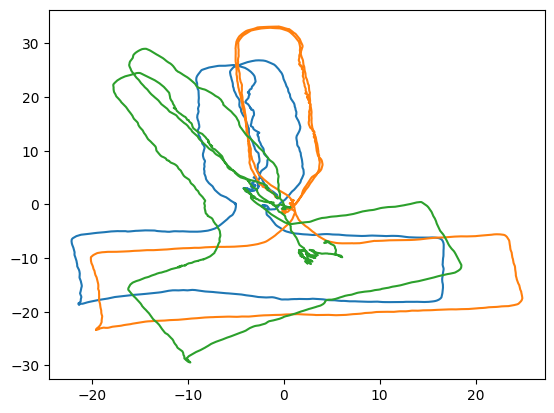

In [55]:
pos_pred = recon_traj_with_preds(seq_dataset, preds_all)[:, :2]
pos_gt = seq_dataset.gt_pos[0][:, :2]

adv_pos_pred = recon_traj_with_preds(seq_dataset, adversarial_preds_all)[:, :2]

plt.plot(pos_pred[:, 0], pos_pred[:, 1])
plt.plot(pos_gt[:, 0], pos_gt[:, 1])
plt.plot(adv_pos_pred[:, 0], adv_pos_pred[:, 1])

In [16]:
#save the results
losses = np.mean((targets_all - preds_all) ** 2, axis=0)
preds_seq.append(preds_all)
targets_seq.append(targets_all)
losses_seq.append(losses)

#compute the predicted trajectory
pos_pred = recon_traj_with_preds(seq_dataset, preds_all)[:, :2]
pos_gt = seq_dataset.gt_pos[0][:, :2]

#compute trajectory errors
traj_lens.append(np.sum(np.linalg.norm(pos_gt[1:] - pos_gt[:-1], axis=1)))
ate, rte = compute_ate_rte(pos_pred, pos_gt, pred_per_min)
ate_all.append(ate)
rte_all.append(rte)
pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)

print('Sequence {}, loss {} / {}, ate {:.6f}, rte {:.6f}'.format
      (test_data_list[dataset_idx], losses, np.mean(losses), ate, rte))

Sequence a006_2, loss [0.01290871 0.01812786] / 0.015518286265432835, ate 3.843045, rte 2.866898


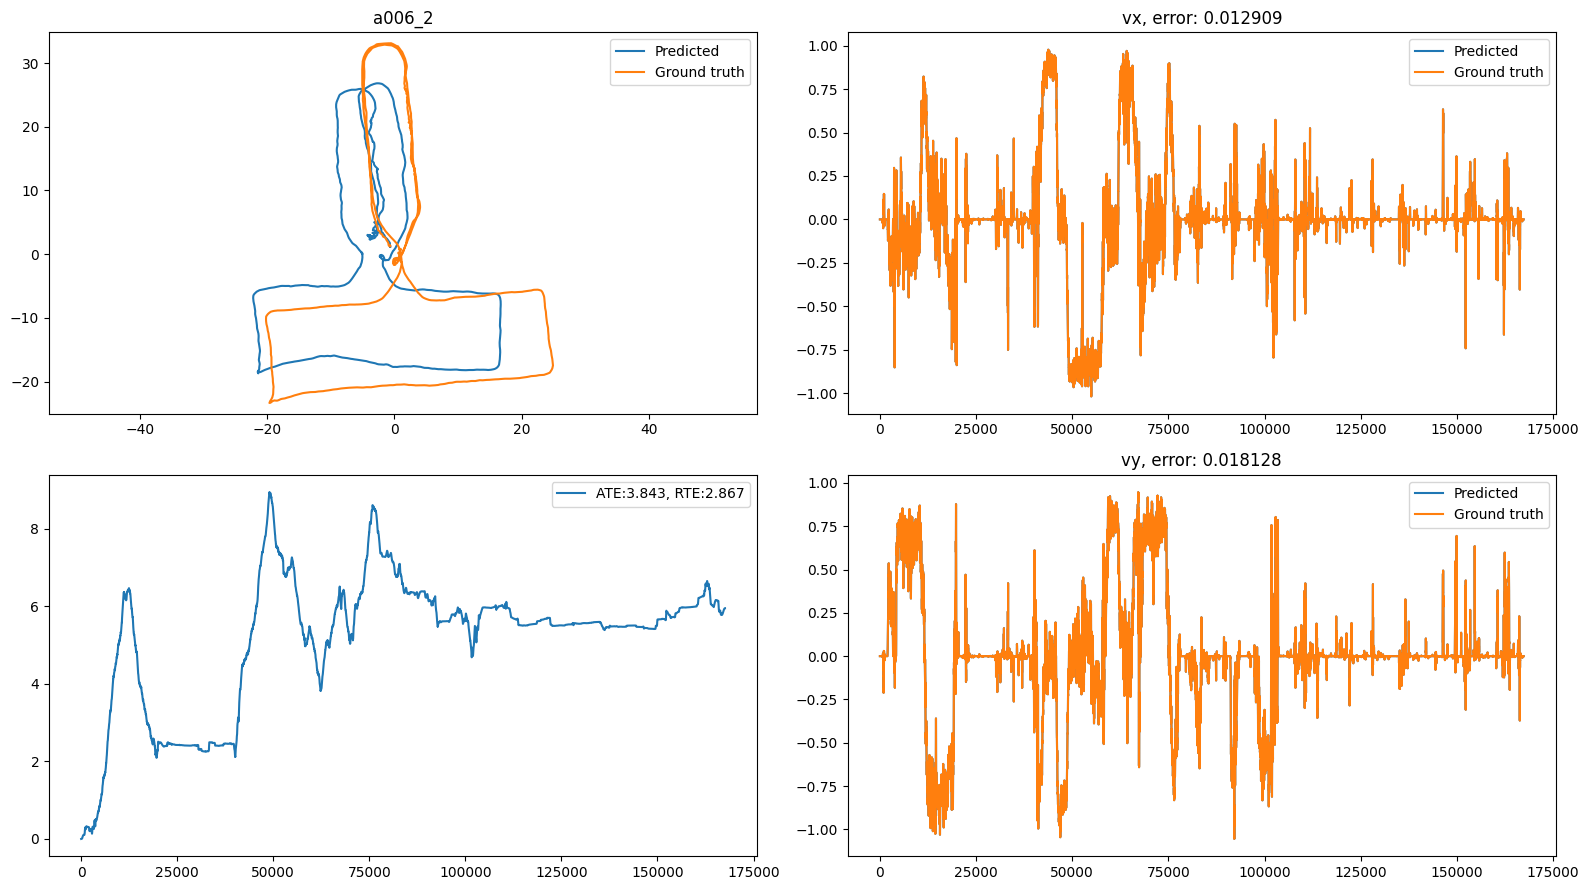

In [17]:
#plot the result
# Plot figures
kp = preds_all.shape[1]
if kp == 2:
    targ_names = ['vx', 'vy']
elif kp == 3:
    targ_names = ['vx', 'vy', 'vz']

plt.figure('{}'.format(test_data_list[dataset_idx]), figsize=(16, 9))
plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
plt.plot(pos_pred[:, 0], pos_pred[:, 1])
plt.plot(pos_gt[:, 0], pos_gt[:, 1])
plt.title(test_data_list[dataset_idx])
plt.axis('equal')
plt.legend(['Predicted', 'Ground truth'])
plt.subplot2grid((kp, 2), (kp - 1, 0))
plt.plot(pos_cum_error)
plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
for i in range(kp):
    plt.subplot2grid((kp, 2), (i, 1))
    plt.plot(ind, preds_all[:, i])
    plt.plot(ind, preds_all[:, i])
    plt.legend(['Predicted', 'Ground truth'])
    plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
plt.tight_layout()
plt.show()

## Computing results of a particular dataset (using their methods)

evaluating on dataset: a006_2
a006_2: device: samsung1, ori_error (game_rv): 3.978
Sequence a006_2, loss [0.01290871 0.01812786] / 0.01551828719675541, ate 3.843045, rte 2.866898


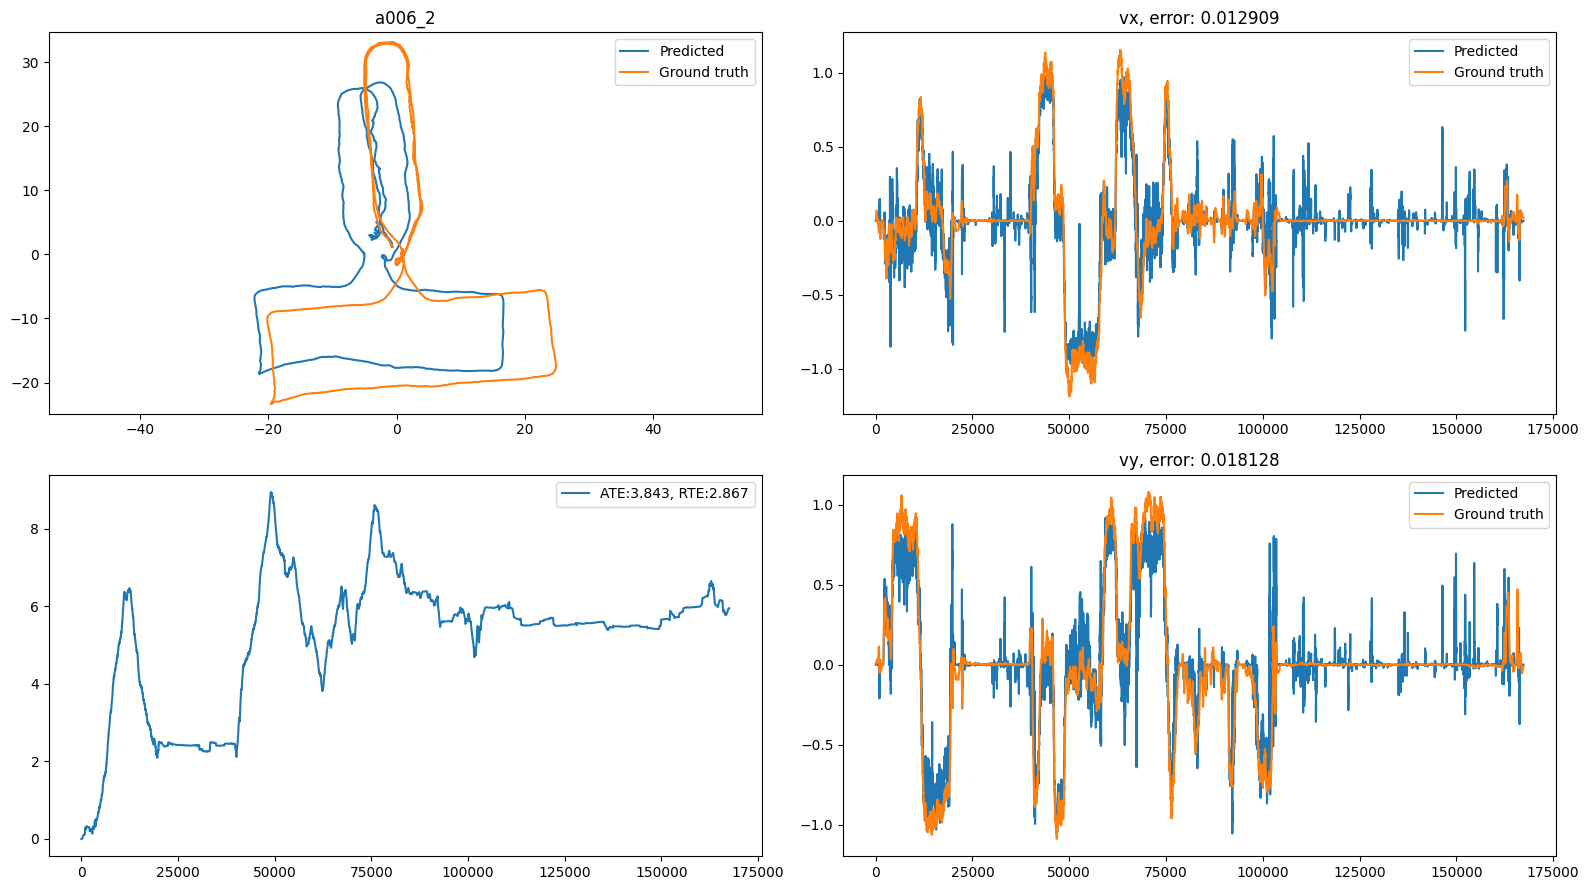

In [19]:
#initialize the dataset
dataset_idx = 0
data = test_data_list[dataset_idx]
print("evaluating on dataset: {}".format(test_data_list[dataset_idx]))
seq_dataset = get_dataset(
    root_dir=root_dir,
    data_list=[data],
    mode="test",
    step_size=step_size,
    window_size=window_size,
    max_ori_error=max_ori_error,
    dataset="ronin",
    cache_path=cache_path
)

seq_loader = DataLoader(dataset=seq_dataset,
                        batch_size=1024,
                        shuffle=False)
ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=np.int32)

targets, preds = run_test(network, seq_loader, device, True)
losses = np.mean((targets - preds) ** 2, axis=0)
preds_seq.append(preds)
targets_seq.append(targets)
losses_seq.append(losses)

pos_pred = recon_traj_with_preds(seq_dataset, preds)[:, :2]
pos_gt = seq_dataset.gt_pos[0][:, :2]

traj_lens.append(np.sum(np.linalg.norm(pos_gt[1:] - pos_gt[:-1], axis=1)))
ate, rte = compute_ate_rte(pos_pred, pos_gt, pred_per_min)
ate_all.append(ate)
rte_all.append(rte)
pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)

print('Sequence {}, loss {} / {}, ate {:.6f}, rte {:.6f}'.format(data, losses, np.mean(losses), ate, rte))

# Plot figures
kp = preds.shape[1]
if kp == 2:
    targ_names = ['vx', 'vy']
elif kp == 3:
    targ_names = ['vx', 'vy', 'vz']

plt.figure('{}'.format(data), figsize=(16, 9))
plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
plt.plot(pos_pred[:, 0], pos_pred[:, 1])
plt.plot(pos_gt[:, 0], pos_gt[:, 1])
plt.title(data)
plt.axis('equal')
plt.legend(['Predicted', 'Ground truth'])
plt.subplot2grid((kp, 2), (kp - 1, 0))
plt.plot(pos_cum_error)
plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
for i in range(kp):
    plt.subplot2grid((kp, 2), (i, 1))
    plt.plot(ind, preds[:, i])
    plt.plot(ind, targets[:, i])
    plt.legend(['Predicted', 'Ground truth'])
    plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
plt.tight_layout()
plt.show()